In [ ]:
! nvidia-smi

Thu Jun 15 18:30:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

from Model_2 import *
from utils import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train = datasets.MNIST('../data/MNIST', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test = datasets.MNIST('../data/MNIST', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

100%|██████████| 9912422/9912422 [00:00<00:00, 466414378.04it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 91699995.32it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 174489501.62it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7663125.01it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device("cuda" if cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model.
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
# test till help to check accuracy of our model

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#return_image_stats(train)
# Since the train data is already Normalized, we will not get the actual mean and std values

torch.Size([128, 1, 28, 28])
torch.Size([128])


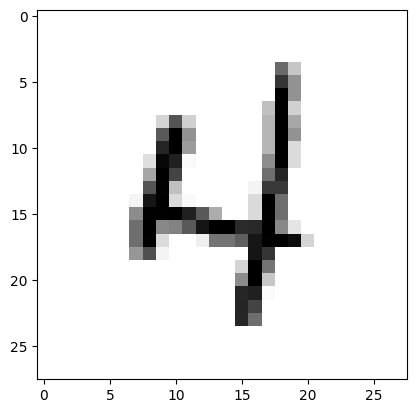

In [ ]:
return_single_image(train_loader)

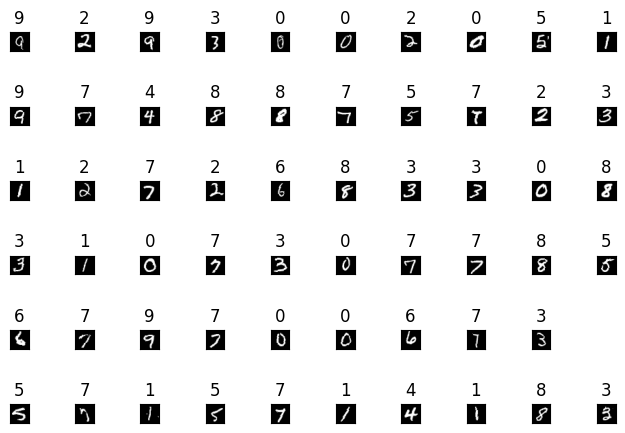

In [ ]:
return_dataset_images(train_loader,60)

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,600
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 16, 12, 12]           1,024
       BatchNorm2d-6           [-1, 16, 12, 12]              32
              ReLU-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           2,304
       BatchNorm2d-9           [-1, 16, 10, 10]              32
             ReLU-10           [-1, 16, 10, 10]               0
          Dropout-11           [-1, 16, 10, 10]               0
           Conv2d-12           [-1, 10, 10, 10]             160
      BatchNorm2d-13           [-1, 10, 10, 10]              20
             ReLU-14           [-1, 10,

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.1678253412246704 Batch_id=468 Accuracy=90.99: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]



Test set: Average loss: 0.1506, Accuracy: 9698/10000 (96.98%)

EPOCH: 2


Loss=0.1893952339887619 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]



Test set: Average loss: 0.0924, Accuracy: 9784/10000 (97.84%)

EPOCH: 3


Loss=0.0922771766781807 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]



Test set: Average loss: 0.0947, Accuracy: 9785/10000 (97.85%)

EPOCH: 4


Loss=0.10193181037902832 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]



Test set: Average loss: 0.0630, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.0426219217479229 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]



Test set: Average loss: 0.0559, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.09512108564376831 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]



Test set: Average loss: 0.0451, Accuracy: 9887/10000 (98.87%)

EPOCH: 7


Loss=0.07274423539638519 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]



Test set: Average loss: 0.0438, Accuracy: 9891/10000 (98.91%)

EPOCH: 8


Loss=0.03653738275170326 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]



Test set: Average loss: 0.0405, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.061200711876153946 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:21<00:00, 21.53it/s]



Test set: Average loss: 0.0457, Accuracy: 9879/10000 (98.79%)

EPOCH: 10


Loss=0.12307996302843094 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]



Test set: Average loss: 0.0394, Accuracy: 9891/10000 (98.91%)

EPOCH: 11


Loss=0.019507532939314842 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]



Test set: Average loss: 0.0359, Accuracy: 9906/10000 (99.06%)

EPOCH: 12


Loss=0.0708511471748352 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.0337, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.03528904542326927 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]



Test set: Average loss: 0.0330, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.04224129021167755 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]



Test set: Average loss: 0.0330, Accuracy: 9902/10000 (99.02%)

EPOCH: 15


Loss=0.044423457235097885 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0281, Accuracy: 9935/10000 (99.35%)



In [ ]:
train_losses

[tensor(2.3368, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3174, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2992, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2393, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2552, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1662, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1488, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0422, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0062, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.9754, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.8919, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.9240, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.8560, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.7885, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.8263, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.7263, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

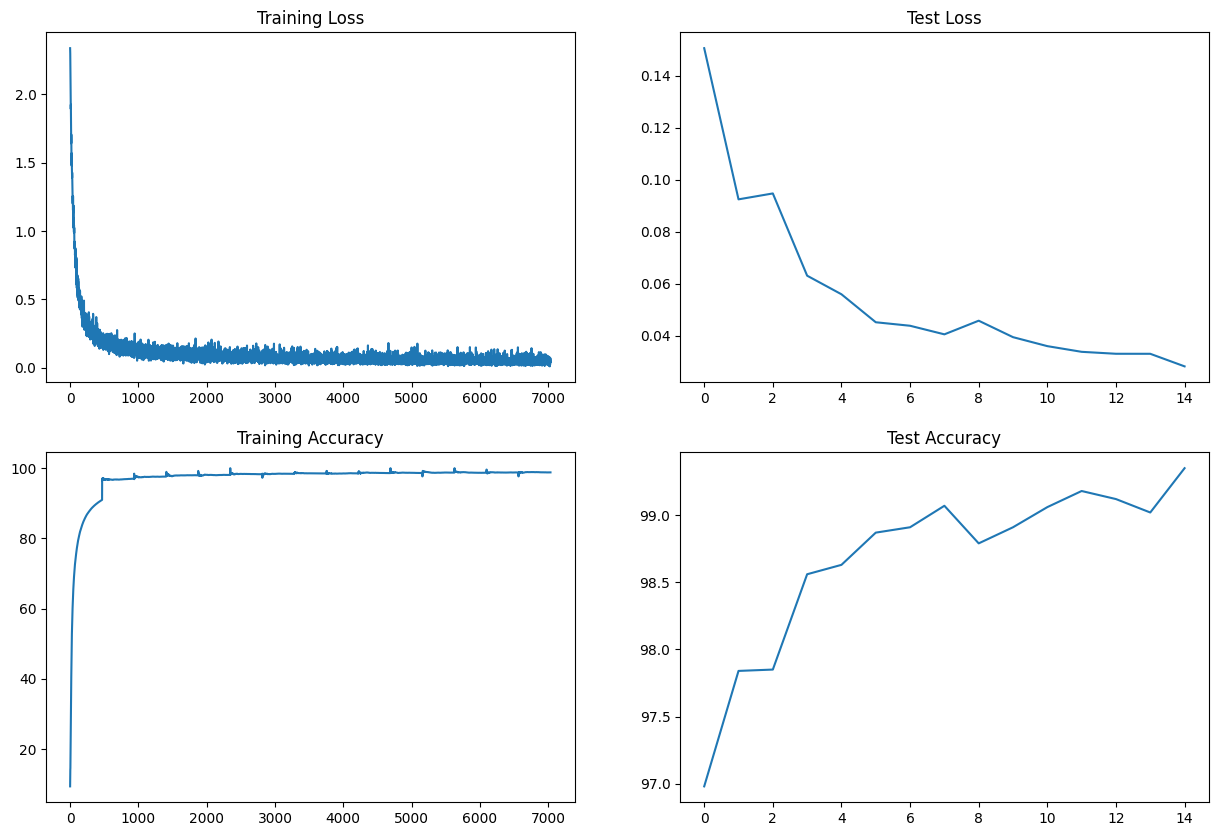

In [ ]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)